**(WORK IN PROGRESS)**

# Rationale

The starting point is the consideration that there is a huge problem with housing and tourism in Madrid: it is known that many private owners find more profitable and lucrative to rent out apartments to tourist than to locals (especially in the city center), and many estate agencies buy properties and convert them to tourist accommodations, too. All of which has the effect of reducing the offer, increasing the prices and pushing locals to other suburban neighbourhoods, leaving only tourists in the center.

With this in mind, and knowing that Airbnb is nowadays one of the biggest most popular online marketplaces for accommodations, I looked into the data to:
- on one hand evaluate the impact Airbnb has on housing in Madrid;
- on the other hand investigate about who, when and how rents out in Madrid and possibly make considerations about tourism flows in Madrid.

# Approach

1. For the first point I mainly looked at listings. 

    The points that need to be addressed are:
     - **Listings types**: Airbnb initial idea was to offer a room or a shared room inside one's own house. Is it still so?
     - **Listings density**: are listings evenly distributed across all the neighbourhoods or there are some *hot* areas?
     - **Ownership**: are properties owned by single private users or are there are users that own and rent out multiple places (i.e. possibly speculating)?
     - **Price fairness**: are prices inflated for tourists? That is, is there a significative difference in prices between listings in English (i.e. for tourists) and Spanish (i.e. "locals", or at least Spanish-speaking tourists)? If there is, is this difference stronger in certain districts?
     
2. For the second part I looked more into reviews. Since we do not have historic data about stays but only about reviews, we could use reviews as estimators of stays/visits.

    Here what we want to see is:
    - **Trend**: has the number of reviews increased over time? If it has, can we say that the increment is due to an increased number of visitors or it must be simply abscribed to an increment in the popularity of the platform?
    - **Seasonality**: is the flow of tourists seasonal, that is does it follow a seasonal trend? Can we explain the pattern?
     

In [1]:
%matplotlib inline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sps    

from langdetect import detect
def mydetect(text):
    try:
        return detect(text)
    except:
        return np.nan

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

plt.rcParams['figure.facecolor'] = 'w'

/kaggle/input/madrid-airbnb-data/neighbourhoods.csv
/kaggle/input/madrid-airbnb-data/calendar.csv
/kaggle/input/madrid-airbnb-data/reviews_detailed.csv
/kaggle/input/madrid-airbnb-data/reviews.csv
/kaggle/input/madrid-airbnb-data/listings_detailed.csv
/kaggle/input/madrid-airbnb-data/neighbourhoods.geojson
/kaggle/input/madrid-airbnb-data/listings.csv


In [2]:
plt.rcParams['figure.facecolor'] = 'w'

# Part I - Housing

In [3]:
listings_detail_df = pd.read_csv(
    '/kaggle/input/madrid-airbnb-data/listings_detailed.csv',
    true_values=['t'], false_values=['f'], na_values=[None, 'none'])

listings_detail_df[['price', 'cleaning_fee']] = (
    listings_detail_df[['price', 'cleaning_fee']]
    .apply(lambda col: (
        col
        .str[1:]
        .str.replace(',', '')
        .apply(float)))
    .fillna(0))

listings_detail_df['minimum_cost'] = (
    listings_detail_df['price'] * 
    listings_detail_df['minimum_nights'] + 
    listings_detail_df['cleaning_fee'])

listings_detail_df['minimum_cost_per_night'] = (
    listings_detail_df['minimum_cost'] /
    listings_detail_df['minimum_nights'])

listings_detail_df['minimum_cost_per_night_and_person'] = (
    np.round(
        listings_detail_df['minimum_cost_per_night'] /
        listings_detail_df['accommodates'], 2))

listings_detail_df['n_amenities'] = (
    listings_detail_df['amenities']
    .str[1:-1]
    .str.replace("\"", '')
    .str.split(',')
    .apply(len))

amenities_srs = (
    listings_detail_df
    .set_index('id')
    ['amenities']
    .str[1:-1]
    .str.replace("\"", '')
    .str.split(',', expand=True)
    .stack())

listings_detail_df['accommodates_group'] = (
    listings_detail_df['accommodates']
    .pipe(pd.cut, bins=[1,2,3,5,20], include_lowest=True, right=False, 
          labels=['Single', 'Couple', 'Family', 'Group']))

listings_lite_df = listings_detail_df[[
    'id', 'host_id', 'listing_url', 'room_type', 'neighbourhood_group_cleansed', 
    'price', 'cleaning_fee', 'accommodates', 'accommodates_group',
    'minimum_nights', 'minimum_cost', 
    'minimum_cost_per_night', 'minimum_cost_per_night_and_person',
    'n_amenities', 'review_scores_rating', 
    'latitude', 'longitude', 'is_location_exact']].copy()

# listings_lite_df.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


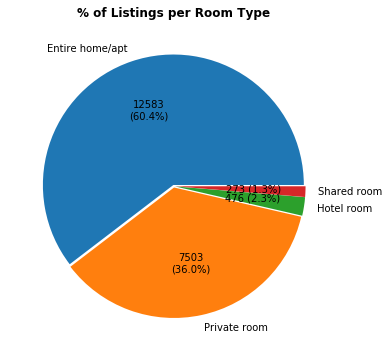

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
pie_data = (
    listings_lite_df['room_type']
    .value_counts())
(pie_data
 .plot(kind='pie', 
       autopct=lambda v: (
           '{}'.format(int(v/100*sum(pie_data))) +
           '\n' * int(v > 10) + ' ' * int(v <= 10) +
           '({:.1%})'.format(v/100)),
       explode=(0.01, ) * len(pie_data),
       ax=ax))
ax.set_ylabel('')
ax.set_title('% of Listings per Room Type', weight='bold')
plt.show()

We can already notice that despite Airbnb being originally created to share rooms, in Madrid more than 60% of the listings are actually about entire homes or apartments or even hotel rooms, while private and shared rooms make less than 40%. This is already an alarming piece of information.

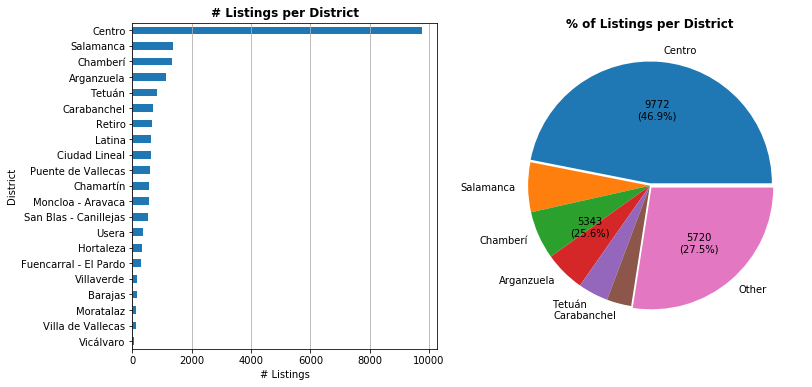

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

n_listings_per_district = (
    listings_lite_df['neighbourhood_group_cleansed']
     .value_counts())

(n_listings_per_district.iloc[::-1]).plot(kind='barh', ax=ax1)

ax1.grid(axis='x')
ax1.set_title('# Listings per District', weight='bold')
ax1.set_ylabel('District')
ax1.set_xlabel('# Listings')

pie_data = (
    n_listings_per_district
    .rename(index={v: 'Other' for v in n_listings_per_district.index[6:]})
    .groupby(level=0, sort=False)
    .sum())
pie2_data = (
    pie_data
    .groupby(lambda v: v if v in ['Centro', 'Other'] else '', sort=False)
    .sum())

(pie_data
 .plot(kind='pie', 
       explode=(0.02, 0, 0, 0, 0, 0, 0.02),
       ax=ax2))
(pie2_data
 .rename(index=lambda v: '')
 .plot(kind='pie', 
       explode=(0.02, 0, 0.02),
       autopct=lambda v: (
           '{}'.format(int(v/100*sum(pie_data))) +
           '\n' + '({:.1%})'.format(v/100)),
       wedgeprops={'alpha': 0},
       ax=ax2))

ax2.set_title('% of Listings per District', weight='bold')
ax2.set_ylabel('')

plt.show()

When we look at the proportion of listings per neighbourhood, things get even worse. The old city center (i.e. the neighbourhood called *Centro*) has almost 50% of the listings. That is, the center is extremely packed with Airbnbs. But are these places apartments or rooms?

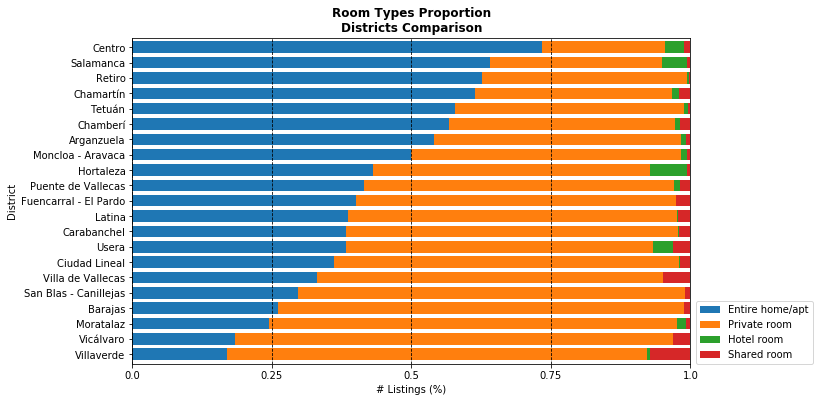

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

barplot_data = (
    listings_lite_df
    .groupby(['neighbourhood_group_cleansed', 'room_type'])
    .size()
    .unstack('room_type')
    .fillna(0)
    .apply(lambda row: row / row.sum(), axis=1)
    .sort_values('Entire home/apt')
    .reindex(columns=listings_lite_df['room_type'].value_counts().index))

barplot_data.plot(kind='barh', width=.75, stacked=True, ax=ax)

ax.set_xticks(np.linspace(0,1, 5))
ax.set_xticklabels(np.linspace(0,1, 5))
ax.grid(axis='x', c='k', ls='--')
ax.set_xlim(0,1)

ax.set_ylabel('District')
ax.set_xlabel('# Listings (%)')
ax.legend(loc=(1.01, 0))

ax.set_title('Room Types Proportion\nDistricts Comparison', weight='bold')

plt.show()

Here we see that nearly 75% of the listings in the *Centro* district are actually entire apartments. Putting this piece of information together with what we've just seen, we can say that there are around 75% x 9772 = 7329 apartments or homes in the center which are listed on Airbnb. Absolutely mind-blowing, especially if we consider how small the neighbourhood is!

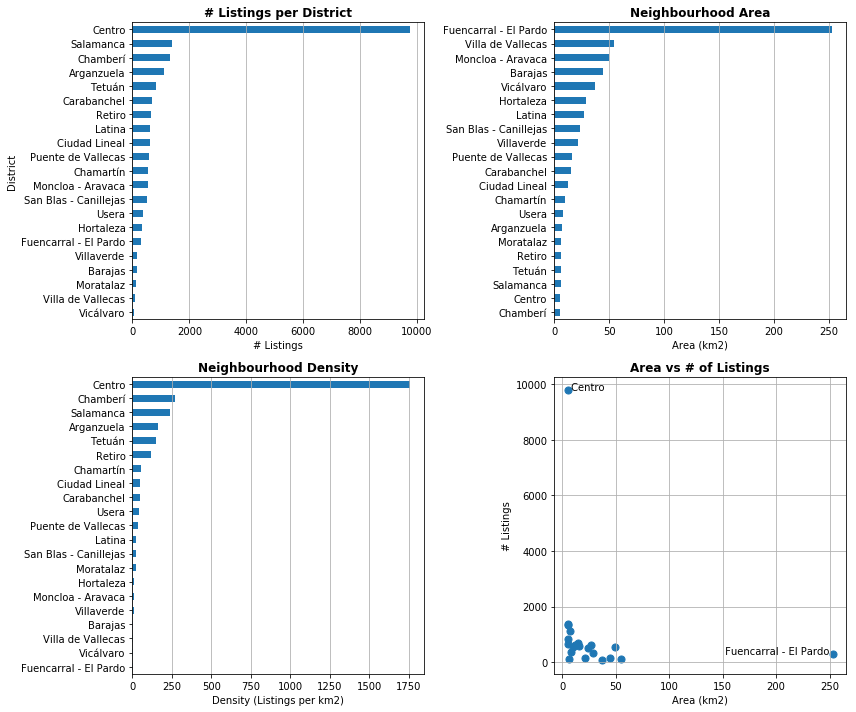

In [7]:
import json
from shapely.geometry import MultiPolygon
with open('/kaggle/input/madrid-airbnb-data/neighbourhoods.geojson') as f:
    geojson = json.loads(f.read())
areas = [{'area': MultiPolygon(feature['geometry']['coordinates'], context_type='geojson').area, 
          **feature['properties']} for feature in geojson['features']]
areas_srs = (
    pd.DataFrame(areas)
    .groupby('neighbourhood_group')
    ['area']
    .sum() * 10**4)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

(n_listings_per_district.iloc[::-1]).plot(kind='barh', ax=ax1)

ax1.grid(axis='x')
ax1.set_title('# Listings per District', weight='bold')
ax1.set_ylabel('District')
ax1.set_xlabel('# Listings')

areas_srs.sort_values().plot(kind='barh', ax=ax2)

ax2.set_title('Neighbourhood Area', weight='bold')
ax2.grid(axis='x')
ax2.set_ylabel('')
ax2.set_xlabel('Area (km2)')

n_listings_per_district.divide(areas_srs).sort_values().plot(kind='barh', ax=ax3)

ax3.set_title('Neighbourhood Density', weight='bold')
ax3.set_xlabel('Density (Listings per km2)')
ax3.grid(axis='x')

scatter_data = pd.concat([n_listings_per_district.rename('n_listings'), areas_srs], axis=1, sort=False)

scatter_data.plot(kind='scatter', x='area', y='n_listings', s=50, ax=ax4)
ax4.set_xlabel('Area (km2)')
ax4.set_ylabel('# Listings')
ax4.set_title('Area vs # of Listings', weight='bold')
ax4.grid(which='both')
ax4.text(*scatter_data.loc['Centro'].values[::-1], ' Centro')
ax4.text(*scatter_data.loc['Fuencarral - El Pardo'].values[::-1], ' Fuencarral - El Pardo ', ha='right')

fig.tight_layout()
plt.show()

*Centro* is indeed the second smallest neighbourhood in the whole city behind *Chamberi*, yet it almost 6 times more densely occupied by Airbnbs, with almost 1800 properties per square kilometer! Plotting the neighbourhoods by area against number of listings we can observe even better that *Centro* is an absolute outlier and it is out of control. This feels the result of gentrification and speculation. At this point it would be also interesting to see if Centro has the highest number of listings per host, which would suggest that listings in the Center are managed by many users that are actually agencies. 

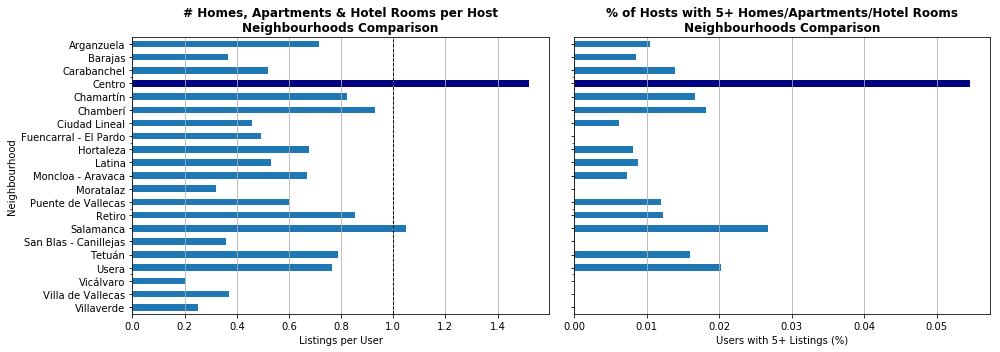

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

hosts_per_neighbourhood = listings_lite_df.groupby('neighbourhood_group_cleansed')['host_id'].nunique()

listings_per_host_per_neighbourhood = (
    (listings_lite_df[
        listings_lite_df['room_type']
        .isin(['Entire home/apt', 'Hotel room'])]
    .groupby('neighbourhood_group_cleansed')
    .size() / hosts_per_neighbourhood)
    .iloc[::-1]
)

multiple_listings_perc_per_neighbourhood = (
    (listings_lite_df
    [listings_lite_df['room_type'].isin(['Entire home/apt', 'Hotel room'])]
    .groupby(['neighbourhood_group_cleansed', 'host_id'])
    .size().ge(5)
    .groupby('neighbourhood_group_cleansed')
    .sum() / hosts_per_neighbourhood)
    .iloc[::-1]
)

(listings_per_host_per_neighbourhood
 .plot(kind='barh', color=[sns.color_palette()[0] 
                           if n != 'Centro' else 'navy' 
                           for n in listings_per_host_per_neighbourhood.index], ax=ax1))

(multiple_listings_perc_per_neighbourhood
 .plot(kind='barh', color=[sns.color_palette()[0] 
                           if n != 'Centro' else 'navy' 
                           for n in multiple_listings_perc_per_neighbourhood.index], ax=ax2))

ax1.grid(axis='x')
ax2.grid(axis='x')
ax1.set_ylabel('Neighbourhood')
ax1.set_xlabel('Listings per User')
ax2.set_xlabel('Users with 5+ Listings (%)')
ax1.axvline(1, c='k', ls='--', lw=.9)

ax1.set_title('# Homes, Apartments & Hotel Rooms per Host\nNeighbourhoods Comparison', weight='bold')
ax2.set_title('% of Hosts with 5+ Homes/Apartments/Hotel Rooms\nNeighbourhoods Comparison', weight='bold')

fig.tight_layout()
plt.show()

These two plots confirm our concerns. Here we see that indeed *Centro* has the highest concentration of homes and apartments per host (left) and the highest percentage of hosts with 5 or more entire properties listed (on the right), which should be possible only for agencies and other speculative entities.

Let's look some more into the hosts. Ideally, one host should have only one property on rent.

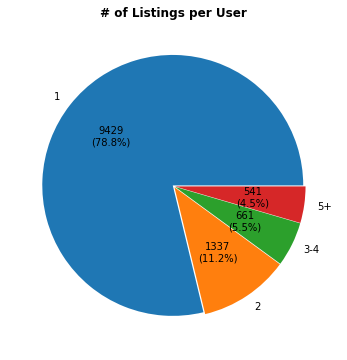

In [9]:
fig, ax = plt.subplots(figsize=(6,6))

n_listings_per_user = (
    listings_lite_df
    .groupby('host_id')
    .size())

pie_data = (
    n_listings_per_user
    .pipe(pd.cut, bins=[1,2,3,5,1000], include_lowest=True, right=False,
       labels=['1', '2', '3-4', '5+']).value_counts())

pie_data.plot(kind='pie',
              explode=(0.01, ) * len(pie_data),
              autopct=lambda v: (
                  '{}'.format(int(v/100*sum(pie_data))) +
                  '\n' + '({:.1%})'.format(v/100)),)

ax.set_ylabel('')
ax.set_title('# of Listings per User', weight='bold')

plt.show()

In [10]:
n_listings_per_user.sort_values().iloc[::-1].head(10).to_frame('n_properties')

,n_properties
host_id,
102947901,231
261942593,156
206349691,124
99018982,110
28038703,108
32046323,83
107141654,66
5542111,62
28786243,58


Still, we see that there is a 20% of users that rents out more than 1 property and there is a 5% of users (541!) that has 5 or more properties listed. This may not sound so bad at first, but now think that every 5 users 1 has at least 2 properties! Also, we can see that there are users with 100+ properties, and one user with 231 listings! Shouldn't Airbnb ban them?

Now let's look at the same problem from another perspective. How many properties are rented out by an owner with multiple properties?

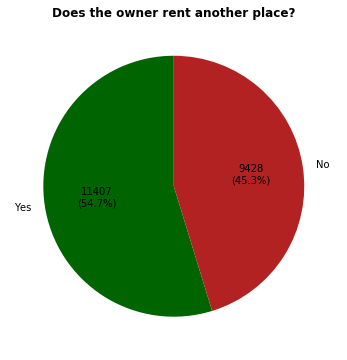

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

pie_data = (
    listings_lite_df['host_id']
    .map(listings_lite_df.groupby('host_id').size() > 1).value_counts())

pie_data.plot(
    kind='pie', labels=['Yes', 'No'], colors=['darkgreen', 'firebrick'], 
    autopct=lambda v: (
                  '{}'.format(int(v/100*sum(pie_data))) +
                  '\n' + '({:.1%})'.format(v/100)),
    startangle=90, ax=ax)

ax.set_ylabel('')
ax.set_title('Does the owner rent another place?', weight='bold')

plt.show()

This is absolutely astonishing to me. 55% of the properties listed for Madrid, that is the majority, are owned by an user which has another property. However this piece of data can be affected by users that share multiple rooms in the same properties. Let's see how many users that own an entire property rent out more.

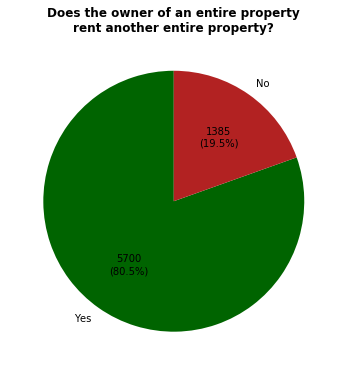

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

pie_data = (
    listings_lite_df[
        listings_lite_df['room_type'].isin(['Entire home/apt', 'Hotel room'])]
    .groupby('host_id')
    .size()
    .gt(1)
    .value_counts())

pie_data.plot(
    kind='pie', labels=['Yes', 'No'], colors=['darkgreen', 'firebrick'], 
    autopct=lambda v: (
                  '{}'.format(int(v/100*sum(pie_data))) +
                  '\n' + '({:.1%})'.format(v/100)),
    startangle=90, ax=ax)

ax.set_ylabel('')
ax.set_title('Does the owner of an entire property\nrent another entire property?', weight='bold')

plt.show()

Wow! That's a truly shocking and alarming piece of information. More than 80% of users who rent an entire property have at least another property listed.

Now let's have a look at prices.

In [13]:
listings_lite_df['name_lang'] = listings_detail_df['name'].apply(mydetect)

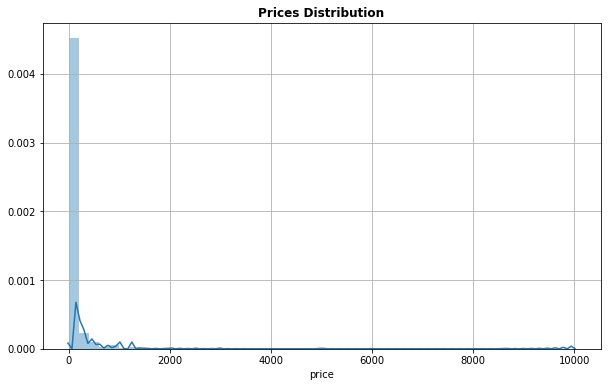

In [14]:
plt.figure(figsize=(10,6))
sns.distplot(listings_lite_df['price'])
plt.title('Prices Distribution', weight='bold')
plt.grid()

plt.show()

We see that prices are extremely skewed, with outliers having prices above 1000. Personally, I cannot thing about spending more than 300 per night in Madrid, so I will keep only listings with prices below this threshold.

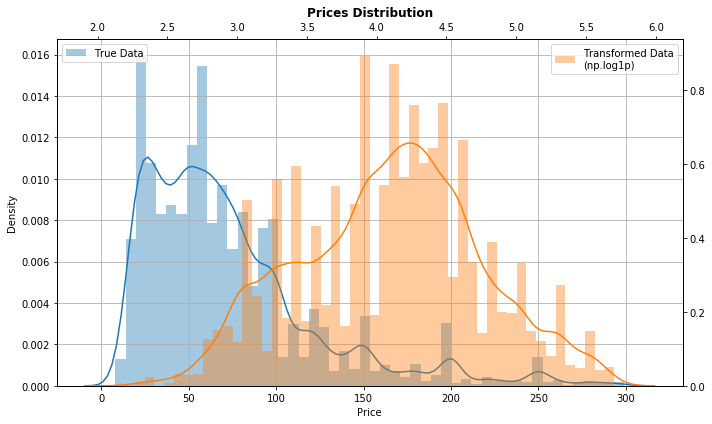

In [15]:
listings_lite_df = listings_lite_df[listings_lite_df['price'] < 300]
trans_prices = listings_lite_df['price'].pipe(np.log1p)

fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twiny().twinx()

sns.distplot(listings_lite_df['price'], ax=ax, label='True Data')
sns.distplot(trans_prices, color=sns.color_palette()[1], ax=ax2, label='Transformed Data\n(np.log1p)')
ax.set_title('Prices Distribution', weight='bold')
ax.grid()
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_xlabel('Price')
ax.set_ylabel('Density')

fig.tight_layout()
plt.show()

Since they are still slightly skewed, I normalize prices with a logaritmic transformation.

Let's see if price has different distribution depending on the language. To do this, we will do a graphical evaluation and then we will apply a statistical test (T-test for independent samples).

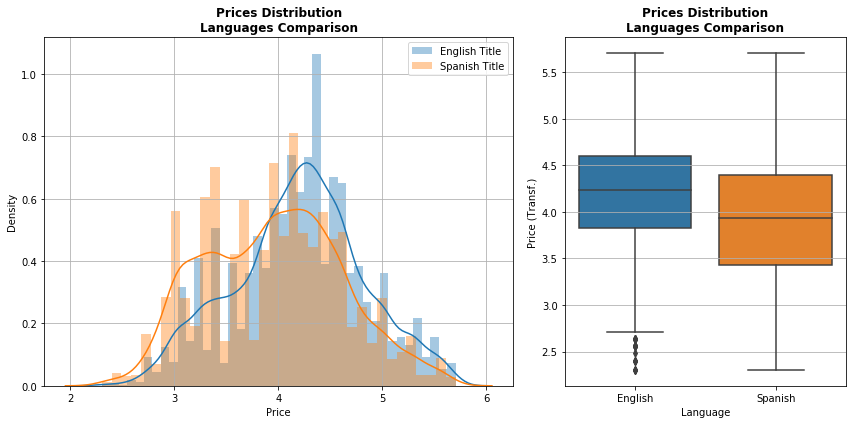

In [16]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios': [1, .6]})

sns.distplot(trans_prices[listings_lite_df['name_lang'] == 'en'], ax=ax, label='English Title')
sns.distplot(trans_prices[listings_lite_df['name_lang'] == 'es'], ax=ax, label='Spanish Title')

ax.set_title('Prices Distribution\nLanguages Comparison', weight='bold')
ax.set_xlabel('Price')
ax.set_ylabel('Density')
ax.grid()
ax.legend()

sns.boxplot(
    x='name_lang', y='trans_price',
    data=(listings_lite_df[listings_lite_df['name_lang'].isin(['es', 'en'])]
          .assign(trans_price=lambda df: df['price'].pipe(np.log1p))),
    order=['en', 'es'], ax=ax2)

ax2.set_title('Prices Distribution\nLanguages Comparison', weight='bold')
ax2.set_xlabel('Language')
ax2.set_xticklabels(['English', 'Spanish'])
ax2.set_ylabel('Price (Transf.)')
ax2.grid(axis='y')

fig.tight_layout()
plt.show()

The distributions look quite interesting. Both, especially the Spanish one, look bimodal reflecting the presence of different markets for different pockets (at least two, cheap vs expensive listings). However the presence of cheaper listings is much more evident in the Spanish distribution, while it can only be hinted in the English one.

To apply a T-test for independent samples we should check that the samples size match and determine whether the two samples have same variance. 

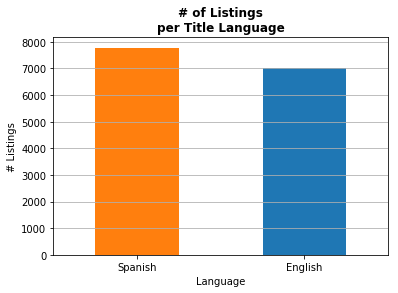

In [17]:
samples = trans_prices.groupby(listings_lite_df['name_lang']).apply(list).loc[['es', 'en']]
samples_sizes = samples.apply(len)

samples_sizes.plot(kind='bar', color=sns.color_palette()[:2][::-1])
plt.title('# of Listings\nper Title Language', weight='bold')
plt.ylabel('# Listings')
plt.xticks([0,1], ['Spanish','English'],rotation=0)
plt.xlabel('Language')
plt.grid(axis='y')

plt.show()

We can say that the listings are evenly distributed among the two languages, so we can proceed.

In [18]:
samples_normality_tests = list(map(sps.normaltest, samples))
samples_normality_tests

[NormaltestResult(statistic=224.51989621755294, pvalue=1.762479188923806e-49),
 NormaltestResult(statistic=41.19239333378641, pvalue=1.1354955573532784e-09)]

Because of such low p-values, we must reject the null hypothesis of normality for both samples (despite transformation). Because of this, we will use Levene's test to check for equal variances.

In [19]:
sps.levene(*samples)

LeveneResult(statistic=61.821729065222364, pvalue=4.0186861306528894e-15)

Also in this case we have a very low p-value, which means we must reject the null hypothesis of equal variance in price between listings in Spanish and listings in English.

In [20]:
sps.ttest_ind(*samples, equal_var=False)

Ttest_indResult(statistic=-22.588506227822624, pvalue=4.27659631806293e-111)

Given the low p-value, we must reject the null hypothesis that these two distributions come from the same distributions. That is, prices for Spanish and English listings are significantly different and on average Spanish listings have lower prices than listings in English. You better learn some Spanish...

# Part II - Tourism Flow

In [21]:
reviews_df = (
    pd.read_csv('/kaggle/input/madrid-airbnb-data/reviews_detailed.csv', 
                parse_dates=['date'])
    .rename(columns={'id': 'review_id'})
    .sort_values('date'))

reviews_df

,listing_id,review_id,date,reviewer_id,reviewer_name,comments
0,6369,29428,2010-03-14,84790,Nancy,Simon and Arturo have the ultimate location in...
1,6369,31018,2010-03-23,84338,David,Myself and Kristy originally planned on stayin...
2,6369,34694,2010-04-10,98655,Marion,We had a great time at Arturo and Simon's ! A ...
3,6369,37146,2010-04-21,109871,Kurt,I very much enjoyed the stay. \r\nIt's a wond...
4,6369,38168,2010-04-26,98901,Dennis,Arturo and Simon are polite and friendly hosts...
...,...,...,...,...,...,...
732657,38342477,532103433,2019-09-19,217852389,Margarita,"Del 1 Al 10 un 7 y es gentil, solo falta que p..."
689390,29898246,532126564,2019-09-19,243539731,Ilija,The host canceled this reservation 3 days befo...
732705,38593197,532075808,2019-09-19,211160518,Светлана,The host canceled this reservation 2 days befo...
689391,29898246,532126806,2019-09-19,29944306,Maria Rosa,The host canceled this reservation the day bef...


Here we can already see few things.
1. Reviews go from 14th of March 2010 to 19th of September 2019, so information in these two years is partial/incomplete;
2. Some reviews are about booking cancellation, which are seemingly automatically posted (look at the last four).
3. As expected, reviews are posted in different languages, mostly in English and Spanish but possibly in many others.

In [22]:
reviews_df2 = (
    reviews_df
    .pipe(pd.merge, (listings_lite_df
                     .rename(columns={'id': 'listing_id'})
                     [['listing_id', 'room_type', 'accommodates_group']])))
reviews_df2 = reviews_df2[reviews_df2['date'].dt.year.between(2011,2018)]

In [23]:
reviews_df = reviews_df[
    reviews_df['comments'].notna() &
    (~reviews_df['comments'].fillna('').str.contains('The host cancel*ed ((my)|(this)) reservation')) &
    (~reviews_df['comments'].fillna('').str.contains('The reservation was cancel*ed'))
].copy()

/opt/conda/lib/python3.6/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


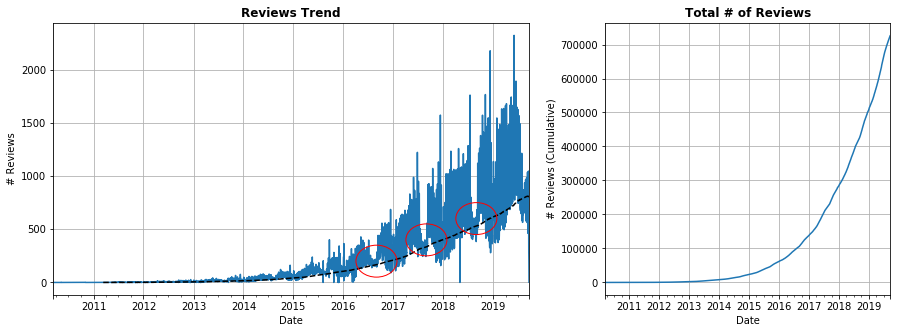

In [24]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [1, .6]})

n_reviews_srs = (
    reviews_df
    .groupby('date')
    .size()
    .reindex(index=pd.date_range(*reviews_df['date'].agg(['min', 'max']).values))
    .fillna(0))

n_reviews_srs.plot(ax=ax)
n_reviews_srs.rolling(365).mean().plot(ax=ax, c='k', ls='--')

ax.set_xlabel('Date')
ax.set_ylabel('# Reviews')
ax.set_title('Reviews Trend', weight='bold')
ax.grid(axis='both')

ax.add_artist(plt.Circle(('2016-08-30',200), radius=150, edgecolor='r', facecolor='None', zorder=3))
ax.add_artist(plt.Circle(('2017-08-30',400), radius=150, edgecolor='r', facecolor='None', zorder=3))
ax.add_artist(plt.Circle(('2018-08-30',600), radius=150, edgecolor='r', facecolor='None', zorder=3))

n_reviews_srs.cumsum().plot(ax=ax2)

ax2.set_xlabel('Date')
ax2.set_ylabel('# Reviews (Cumulative)')
ax2.set_title('Total # of Reviews', weight='bold')
ax2.grid(axis='both')

plt.show()

These plots highlight that:
1. the number of reviews has been growing from 2011;
2. it seems there is a strong seasonality.

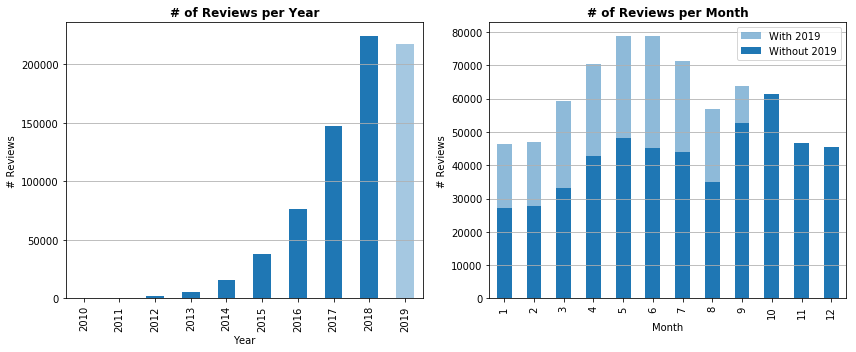

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

n_reviews_per_year = (
    reviews_df
    .groupby(reviews_df['date'].dt.year)
    .size()
    .sort_index())

plot_data = n_reviews_per_year.copy()
plot_data.iloc[-1] = np.nan
plot_data.plot(kind='bar', ax=ax1)
plot_data = n_reviews_per_year.copy()
plot_data.iloc[:-1] = np.nan
plot_data.plot(kind='bar', ax=ax1, alpha=.4)

ax1.set_xlabel('Year')
ax1.set_ylabel('# Reviews')
ax1.set_title('# of Reviews per Year', weight='bold')
ax1.grid(axis='y')

n_reviews_per_month = (
    reviews_df
    .groupby(reviews_df['date'].dt.month)
    .size()
    .sort_index())
n_reviews_per_month_no2019 = (
    reviews_df[reviews_df['date'] < '2019-01-01']
    .groupby(reviews_df['date'].dt.month)
    .size()
    .sort_index())

n_reviews_per_month.plot(kind='bar', ax=ax2, alpha=0.5, label='With 2019')
n_reviews_per_month_no2019.plot(kind='bar', ax=ax2, label='Without 2019')

ax2.set_xlabel('Month')
ax2.set_ylabel('# Reviews')
ax2.set_title('# of Reviews per Month', weight='bold')
ax2.grid(axis='y')
ax2.legend()


fig.tight_layout()
plt.show()

Indeed, if we look at the number of reviews per year we see the number of reviews growing all the years with the only exception of 2019 because it is incomplete.

Also, we can see that the month with the most reviews is October, while the month with the least is January. However, this does not tell us anything about seasonality yet. To see seasonality we should compare years against each other.

But first, can we say something more about this growth? There might be multiple reasons: an increased number of active reviewers (more reviewers > more reviews), an increased number of active listings (more listings > more reviews), or simply an increased number of reviews per listings, that is more travels per user (assuming stays have always the same duration on average). Let's compare these trends:

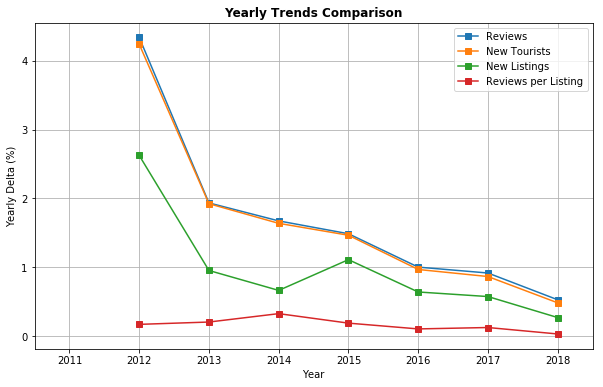

In [26]:
lambda_diff = lambda srs: (srs - srs.shift()) / srs.shift()

fig, ax = plt.subplots(figsize=(10,6))
kwargs = {'marker': 's', 'ax': ax}

n_reviews_per_year.iloc[1:-1].pipe(lambda_diff).plot(label='Reviews', **kwargs)

(reviews_df2
 .groupby('reviewer_id')
 ['date']
 .min()
 .dt.year
 .value_counts()
 .sort_index()
 .pipe(lambda_diff)).plot(label='New Tourists', **kwargs)

(reviews_df2
 .groupby('listing_id')
 ['date']
 .min()
 .dt.year
 .value_counts()
 .sort_index()
 .pipe(lambda_diff)).plot(label='New Listings', **kwargs)

(reviews_df2
.groupby([reviews_df2['date'].dt.year.rename('year'), 'listing_id'])
.size()
.groupby('year')
.mean()
.pipe(lambda_diff)).plot(label='Reviews per Listing', **kwargs)

ax.legend()
ax.grid()
# ax.set_ylim(-2.15, 2.15)
ax.set_xlim(2010.5, 2018.5)
ax.set_xlabel('Year')
ax.set_ylabel('Yearly Delta (%)')
ax.set_title('Yearly Trends Comparison', weight='bold')

plt.show()

Here we can see that the number of new reviews follows the very same trend of new tourists (actually, new reviewers), which seems to be the main driving factor.

Speaking instead about seasonality, here below we count the number of reviews in each week of the year from start to end. Also, to get rid of a bit of noise, we get the moving average across one month (4 weeks). Then we unstack the years and we compare them against each other.

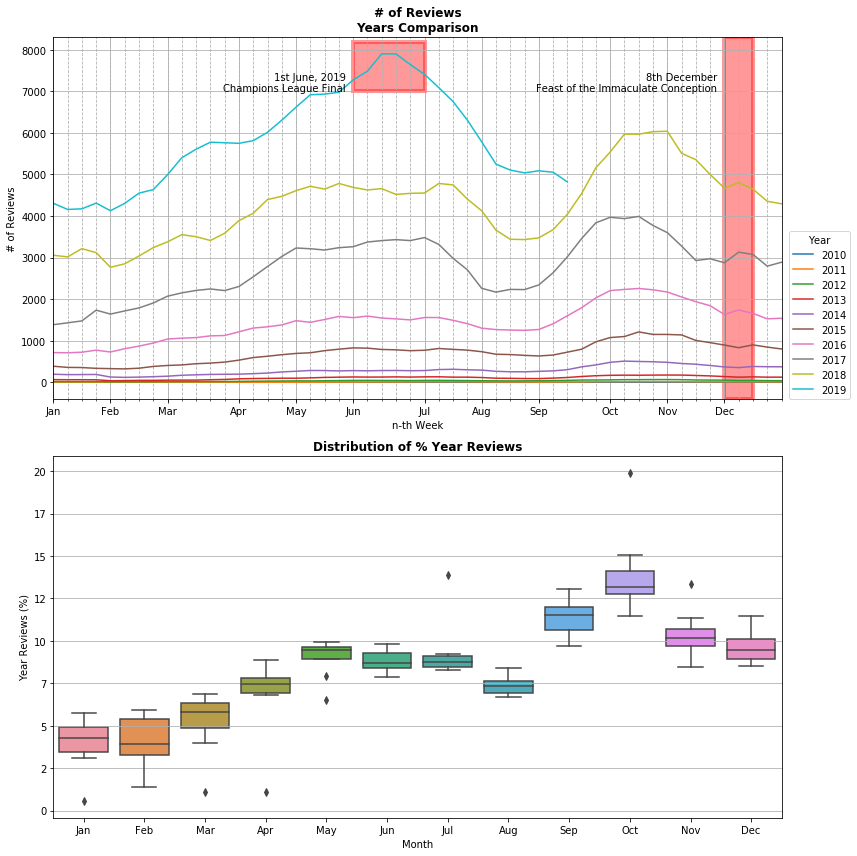

In [27]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 12))

n_reviews_nthweek_x_year_srs = (
    n_reviews_srs
    .groupby([
     n_reviews_srs.index.to_series().dt.year.rename('Year'),
     n_reviews_srs.index.to_series().dt.weekofyear.rename('n-th Week')])
    .sum())

(n_reviews_nthweek_x_year_srs
 .iloc[1:-1]
 .rolling(4)
 .mean()
 .unstack('Year')).plot(ax=ax)

months_dts = [dt for dt in pd.date_range('2019-01-01', '2019-12-31') if dt.is_month_start]
ax.set_xticks([dt.weekofyear for dt in months_dts])
ax.set_xticklabels([dt.strftime('%b') for dt in months_dts])
ax.set_xticks(range(1,53), minor=True)
ax.set_xlim(1, 52)
ax.set_ylabel('# of Reviews')
ax.set_title('# of Reviews\nYears Comparison', weight='bold')
ax.legend(title='Year', loc=(1.01, 0))

ax.add_artist(plt.Rectangle((months_dts[5].weekofyear, 7000), width=5, height=1200,
                            facecolor='r', alpha=.4, edgecolor='r', lw=4))
ax.text(months_dts[5].weekofyear - 0.5, 7000, '1st June, 2019\nChampions League Final', ha='right')
ax.axvspan(months_dts[-1].weekofyear, months_dts[-1].weekofyear+2, 
           facecolor='r', alpha=.4, edgecolor='r', lw=4)
ax.text(months_dts[-1].weekofyear - 0.5, 7000, 
        '8th December\nFeast of the Immaculate Conception', ha='right')
ax.grid(axis='both')
ax.grid(axis='x', which='minor', ls='--')

n_reviews_month_x_year_df = (
    n_reviews_srs
    .groupby([
         n_reviews_srs.index.to_series().dt.year.rename('Year'),
         n_reviews_srs.index.to_series().dt.month.rename('Month')])
    .sum()
    .unstack('Year'))
perc_year_reviews_x_month_df = (
    n_reviews_month_x_year_df
    .divide(n_reviews_month_x_year_df.sum()))

boxplot_data = (
    perc_year_reviews_x_month_df
    .iloc[:, 1:-1]
    .stack()
    .to_frame('% Year Reviews')
    .reset_index())

sns.boxplot(x='Month', y='% Year Reviews', data=boxplot_data, ax=ax2)

ax2.set_xticklabels([
    pd.to_datetime(label.get_text(), format='%m').strftime('%b')
    for label in ax2.get_xticklabels()])
ax2.set_yticklabels([int(tick*100) for tick in ax2.get_yticks()])
ax2.set_ylabel('Year Reviews (%)')
ax2.set_title('Distribution of % Year Reviews', weight='bold')
ax2.grid(axis='y')

fig.tight_layout()
plt.show()

These plots highlight a common pattern accross the years and therefore a strong seasonality. We see how the number of reviews grows almost constantly from January to end of April, then it stabilizes between May and June, then decreases for the summer holidays before growing again in September/October (seemingly in correspondence with the beginning of the academic year) before decreasing once again until end of December.

A possible interpretation for that peak in October could be the beginning of the academic year and the arrival of many students looking for an apartment. If that was the case, we should see an increased proportion of bookings for smaller rooms around those dates.

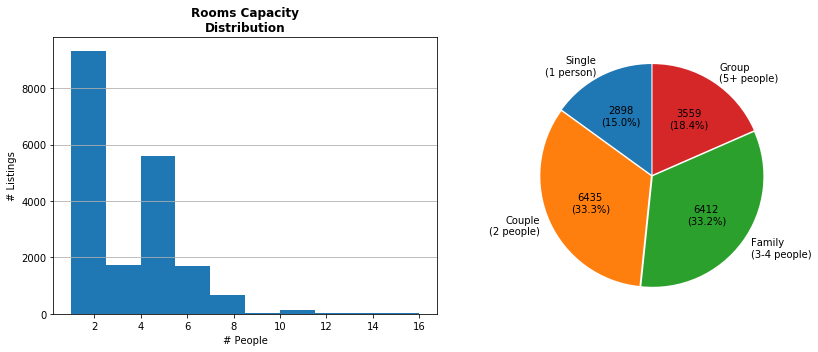

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

listings_lite_df['accommodates'].plot(kind='hist', ax=ax1)

ax1.set_xlabel('# People')
ax1.set_ylabel('# Listings')
ax1.set_title('Rooms Capacity\nDistribution', weight='bold')
ax1.grid(axis='y')

pie_data = (
    listings_lite_df['accommodates_group']
    .value_counts()
    .sort_index())

pie_data.plot(
    kind='pie', 
    labels=['Single\n(1 person)', 'Couple\n(2 people)', 'Family\n(3-4 people)', 'Group\n(5+ people)'],
    autopct=lambda v: (
         '{}'.format(int(v/100*sum(pie_data))) +
         '\n' + '({:.1%})'.format(v/100)),
    startangle=90,
    explode=(0.01, ) * len(pie_data),
    ax=ax2)

ax2.set_ylabel('')

fig.tight_layout()
plt.show()

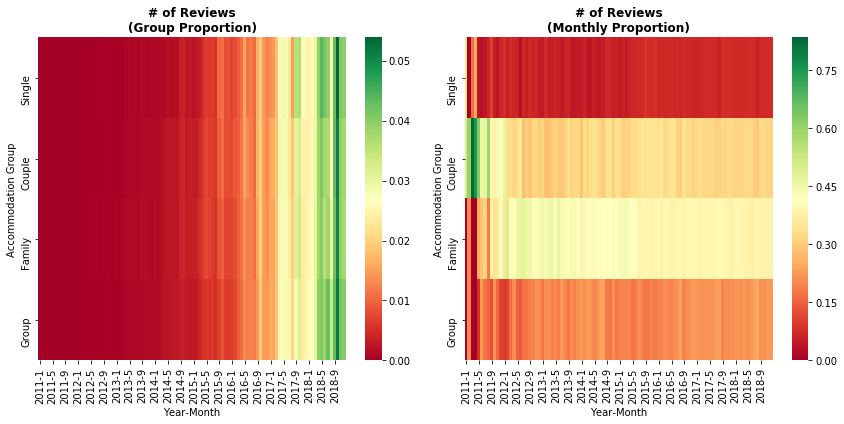

In [29]:
n_reviews_year_month_x_accgroup_df = (
    reviews_df2
    .groupby([
        reviews_df2['date'].dt.year.rename('Year'),
        reviews_df2['date'].dt.month.rename('Month'),
        'accommodates_group'])
    .size()
    .unstack(['accommodates_group'])
    .fillna(0))

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(n_reviews_year_month_x_accgroup_df.T.apply(lambda row: row / row.sum(), axis=1), cmap='RdYlGn', ax=ax)

ax.set_ylabel('Accommodation Group')
ax.set_xlabel('Year-Month')
ax.set_title('# of Reviews\n(Group Proportion)', weight='bold')

sns.heatmap(n_reviews_year_month_x_accgroup_df.T.apply(lambda col: col / col.sum()), cmap='RdYlGn', ax=ax2)

ax2.set_ylabel('Accommodation Group')
ax2.set_xlabel('Year-Month')
ax2.set_title('# of Reviews\n(Monthly Proportion)', weight='bold')

fig.tight_layout()
plt.show()

In these two plots we see how the proportion of reviews changes along time and accross the groups. 
- On the right we see that accross the same group the proportion of reviews grows along time, and that's true for all the accommodation groups. This is due to the fact that as we have seen, the total number of reviews has grown.
- On the other hand on the left we see that in almost any given moment in time the proportion of accommodations for singles and groups is lower than those for family and couple, that is the proportion does not change over time.

Since the accommodation groups have different sizes (right plot), and in general the number of reviews grows each year (left plot), we need to separate different years and normalize the proportion of a group along time.

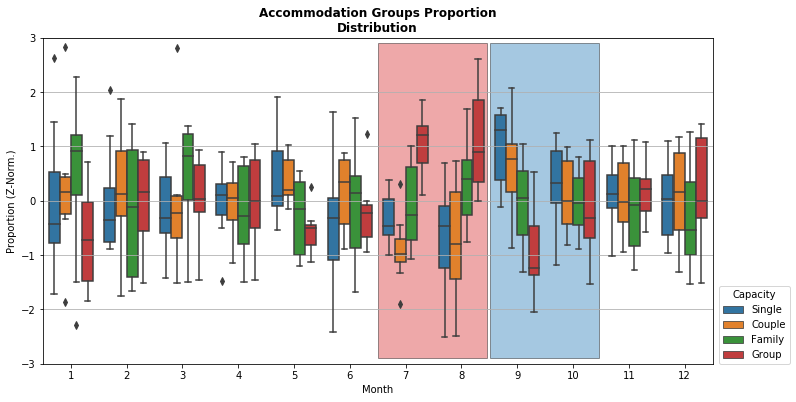

In [30]:
n_reviews_year_month_x_accgroup_df = (
    reviews_df2
    .groupby([
        reviews_df2['date'].dt.year.rename('Year'),
        reviews_df2['date'].dt.month.rename('Month'),
        'accommodates_group'])
    .size()
    .unstack(['accommodates_group'])
    .fillna(0))

znorm_perc_reviews_year_month_x_accgroup_df = (
    n_reviews_year_month_x_accgroup_df
    # per each year and month we compute the proportion of reviews in each "accommodation group"
    .divide(n_reviews_month_x_year_df.stack().swaplevel().sort_index(), axis=0)
    # we normalize this number across months of the same year
    .unstack('Year')
    .apply(lambda col: (col - col.mean()) / col.std())
    .stack('Year')
    .swaplevel()
    .sort_index())

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(x='Month', y='z_perc', hue='accommodates_group', 
            data=(znorm_perc_reviews_year_month_x_accgroup_df
                  .stack()
                  .sort_index()
                  .to_frame('z_perc')
                  .reset_index()), ax=ax)
ax.set_ylabel('Proportion (Z-Norm.)')
ax.set_ylim(-3,3)
ax.set_title('Accommodation Groups Proportion\nDistribution', weight='bold')
ax.grid(axis='y')
ax.add_artist(plt.Rectangle((5.51, -2.9), width=1.95, height=2.9*2, 
                            facecolor=sns.color_palette()[3], edgecolor='k', alpha=.4, zorder=0))
ax.add_artist(plt.Rectangle((7.51, -2.9), width=1.95, height=2.9*2, 
                            facecolor=sns.color_palette()[0], edgecolor='k', alpha=.4, zorder=0))

ax.legend(title='Capacity', loc=(1.01, 0))

plt.show()

Now we can compare proportions and we can see that, indeed, in September-October(-November) there is a higher proportion of reviews (and therefore reservations) for smaller rooms for 1-2 people, possibly rented to students or workers that came to find a new apartment in the city for the new academic/working year. On the contrary, during the summer (July-August) the proportion of small rooms is very low while there is a preference for larger rooms that host families and groups, possibly tourists and large group of friends.

# Conclusions

Summarizing what we've seen:
- The days of couchsurfing are over, the most popular listings are for entire homes or apartments which make around 60% of the listings in Madrid;
- Although it is quite normal for every city to have a higher concentration of accommodations in the center, Madrid's center seems to have a serious problem with gentrification and speculation with an astonishing density of (roughly) 1750 listings per km2 and more than 5% of hosts renting out more than 5+ entire homes.
- More in general, it seems there is a huge problem with speculation as 80% of the hosts that own an entire property actually have at least another flat listed.
- Speaking about listings, those in English have on average (statistically significant) higher prices for night suggesting that tourists may be charged a bit more.
- The number of reviews is growing in absolute terms but the percentual increment is flattening out. Also, the number of reviews follows the very same trend of new users.
- Tourism tren in Madrid seems highly seasonal, with high-season during autumn and low-season during summer (when people presumably go rather to seaside or other resorts); summer is preferred by families and large groups, while couple and solo-travellers actually prefer autumn.